In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization, GlobalAveragePooling2D, Add, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
import time
from skimage.segmentation import mark_boundaries, slic
from skimage.transform import resize
from lime import lime_image
from tensorflow.keras.preprocessing import image
import random
import warnings
warnings.simplefilter("ignore")
from kerastuner import HyperModel, RandomSearch
import pickle

2024-07-25 00:55:23.456201: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 00:55:23.456344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 00:55:23.595353: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_path = '/kaggle/input/facialexprsn/dataset'

data = pd.read_csv('/kaggle/input/facialexprsn/data.csv')

data['path'] = data['path'].apply(lambda x: os.path.join(base_path, x))

def get_image_resolution(img_path):
    if not os.path.exists(img_path):
        return 0, 0
    img = cv2.imread(img_path)
    if img is None:
        return 0, 0
    return img.shape[1], img.shape[0]  # width, height

data[['width', 'height']] = data['path'].apply(lambda x: pd.Series(get_image_resolution(x)))
min_width = 256
min_height = 256
data = data[(data['width'] >= min_width) & (data['height'] >= min_height)]

data['file_size'] = data['path'].apply(lambda x: os.path.getsize(x) if os.path.exists(x) else 0)

data = data.sort_values(by=['label', 'file_size'], ascending=[True, False])

data = data.groupby('label').head(1200)

def preprocess_image(img_path):
    if not os.path.exists(img_path):
        print(f"Error: File not found at path {img_path}")
        return None
    img = cv2.imread(img_path)
    if img is None:
        print(f"Error: Unable to read image at path {img_path}")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.GaussianBlur(img, (3, 3), 0)  # Apply Gaussian Blur
    img = cv2.equalizeHist(img)  # Histogram Equalization
    img = cv2.resize(img, (256, 256))  # Resize to 256x256
    img = img / 255.0  # Normalize pixel values
    return img

data['image'] = data['path'].apply(preprocess_image)
data = data.dropna(subset=['image'])


In [3]:
X = np.array(data['image'].tolist()).reshape(-1, 256, 256, 1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['label'])
y = tf.keras.utils.to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model4 = Sequential([
    Conv2D(64, (3, 3), input_shape=(256, 256, 1)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(256, (3, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(512, (3, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(512, (3, 3)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(1024, (3, 3), name='conv2d_last'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    
    Dense(256),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    
    Dense(512),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    
    Dense(y_train.shape[1], activation='softmax')
])

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:

start_time = time.time()

history = model4.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Epoch 1/50


2024-07-25 01:00:08.798582: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[64,64,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,1,256,256]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-25 01:00:09.675242: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.08747, expected 1.60805
2024-07-25 01:00:09.675311: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.24242, expected 1.76301
2024-07-25 01:00:09.675333: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.64639, expected 2.16697
2024-07-25 01:00:09.675344: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at

56/68 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - accuracy: 0.2050 - loss: 2.3110

2024-07-25 01:01:09.793308: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[57,64,254,254]{3,2,1,0}, u8[0]{0}) custom-call(f32[57,1,256,256]{3,2,1,0}, f32[64,1,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-07-25 01:01:10.438181: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.21459, expected 1.44774
2024-07-25 01:01:10.438243: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.10054, expected 2.33369
2024-07-25 01:01:10.438253: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.00191, expected 2.23506
2024-07-25 01:01:10.438261: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.2075 - loss: 2.2900

2024-07-25 01:01:44.734018: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64522: 2.54951, expected 2.17149
2024-07-25 01:01:44.734080: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64523: 2.74275, expected 2.36473
2024-07-25 01:01:44.734089: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64524: 2.66164, expected 2.28363
2024-07-25 01:01:44.734097: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64526: 2.45939, expected 2.08138
2024-07-25 01:01:44.734105: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64527: 1.95735, expected 1.57934
2024-07-25 01:01:44.734130: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64528: 1.92611, expected 1.5481
2024-07-25 01:01:44.734139: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 64534: 2.77274, expected 2.39472
2024-07-25 01:01:44.734147: 

68/68 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.2076 - loss: 2.2886 - val_accuracy: 0.0957 - val_loss: 2.1096 - learning_rate: 0.0010
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 290ms/step - accuracy: 0.2522 - loss: 1.9827 - val_accuracy: 0.1389 - val_loss: 2.0380 - learning_rate: 0.0010
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.2578 - loss: 1.8407 - val_accuracy: 0.2208 - val_loss: 2.0336 - learning_rate: 0.0010
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 285ms/step - accuracy: 0.2967 - loss: 1.7165 - val_accuracy: 0.2208 - val_loss: 2.3042 - learning_rate: 0.0010
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 290ms/step - accuracy: 0.3287 - loss: 1.6524 - val_accuracy: 0.2530 - val_loss: 2.3669 - learning_rate: 0.0010
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 285ms/step - accuracy: 0.3551 - loss: 1.5681 - val_accuracy: 0.2208 - val_loss: 2.7158 - learning_rate: 0.0010
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 284ms/step - accuracy: 0.3416 - loss: 1.5467 - val_ac

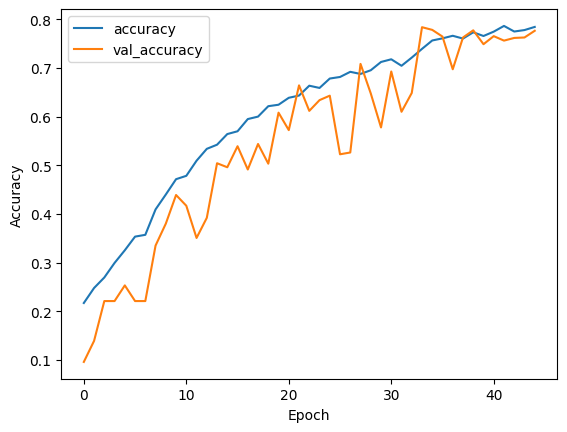

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


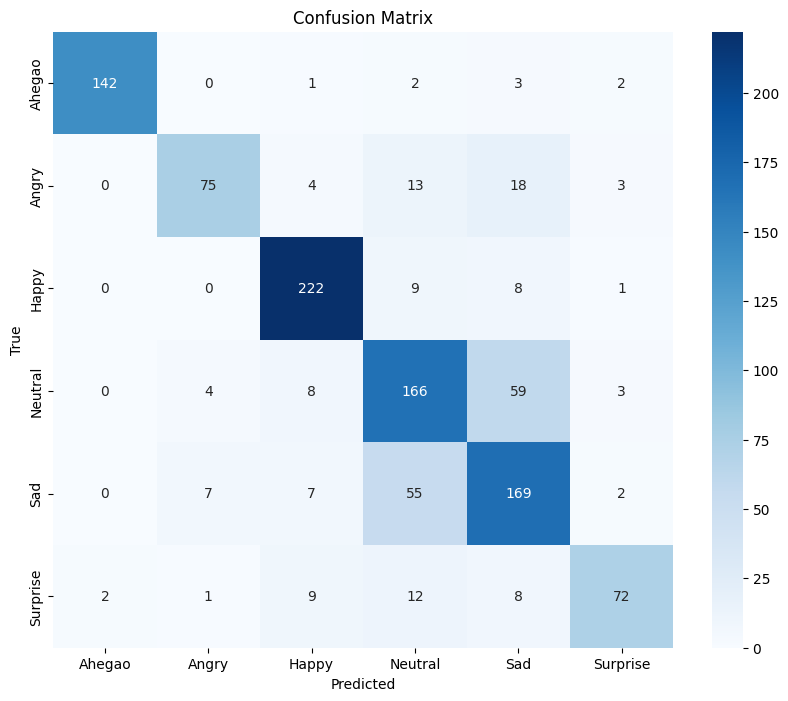

AUC Score: 0.9573189957130673
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97       150
           1       0.86      0.66      0.75       113
           2       0.88      0.93      0.90       240
           3       0.65      0.69      0.67       240
           4       0.64      0.70      0.67       240
           5       0.87      0.69      0.77       104

    accuracy                           0.78      1087
   macro avg       0.81      0.77      0.79      1087
weighted avg       0.79      0.78      0.78      1087



In [6]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Generate predictions
y_pred = model4.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# AUC Score
auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print('AUC Score:', auc)

# Classification Report
print('Classification Report:\n', classification_report(y_true, y_pred_classes))

In [7]:
model4.save("CNN.h5")

In [8]:


def residual_block(x, filters, kernel_size=3):
    res = Conv2D(filters, kernel_size, padding='same')(x)
    res = BatchNormalization()(res)
    res = LeakyReLU(alpha=0.1)(res)
    
    res = Conv2D(filters, kernel_size, padding='same')(res)
    res = BatchNormalization()(res)
    
    if x.shape[-1] != filters:
        x = Conv2D(filters, (1, 1), padding='same')(x)
        x = BatchNormalization()(x)
    
    x = Add()([x, res])
    x = LeakyReLU(alpha=0.1)(x)
    return x

input_layer = Input(shape=(256, 256, 1))
x = Conv2D(32, (3, 3), padding='same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = residual_block(x, 64)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = residual_block(x, 128)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = residual_block(x, 256)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = residual_block(x, 512)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

x = Conv2D(1024, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

x = Dense(256)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.5)(x)

output_layer = Dense(y_train.shape[1], activation='softmax')(x)

resmodel = Model(inputs=input_layer, outputs=output_layer)

# LR scheduler
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

optimizer = Adam(learning_rate=lr_schedule)

resmodel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = resmodel.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)


Epoch 1/100


2024-07-25 01:18:29.567120: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.33053, expected 0.80351
2024-07-25 01:18:29.567199: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.66902, expected 1.14199
2024-07-25 01:18:29.567214: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.77747, expected 1.25044
2024-07-25 01:18:29.567224: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.38984, expected 1.86281
2024-07-25 01:18:29.567237: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.84732, expected 1.32029
2024-07-25 01:18:29.567259: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.02712, expected 1.5001
2024-07-25 01:18:29.567272: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.48193, expected 1.95491
2024-07-25 01:18:29.567283: E external/local_xla/xla/ser

67/68 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.2022 - loss: 2.2170

2024-07-25 01:19:39.281209: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.34739, expected 0.84885
2024-07-25 01:19:39.281278: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.00234, expected 1.50379
2024-07-25 01:19:39.281287: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.36363, expected 1.86509
2024-07-25 01:19:39.281296: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.20014, expected 1.7016
2024-07-25 01:19:39.281303: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.23724, expected 1.73869
2024-07-25 01:19:39.281311: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.67155, expected 2.173
2024-07-25 01:19:39.281319: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.28585, expected 1.78731
2024-07-25 01:19:39.281327: E external/local_xla/xla/servi

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 0.2024 - loss: 2.2151

2024-07-25 01:20:18.895027: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.7617, expected 0.989329
2024-07-25 01:20:18.895092: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.3675, expected 1.59513
2024-07-25 01:20:18.895106: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.99184, expected 2.21947
2024-07-25 01:20:18.895120: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.27093, expected 2.49857
2024-07-25 01:20:18.895132: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.95602, expected 2.18365
2024-07-25 01:20:18.895141: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.29863, expected 2.52627
2024-07-25 01:20:18.895152: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 3.57151, expected 2.79914
2024-07-25 01:20:18.895164: E external/local_xla/xla/ser

68/68 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.2027 - loss: 2.2132 - val_accuracy: 0.1040 - val_loss: 2.7258
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 281ms/step - accuracy: 0.2547 - loss: 1.9385 - val_accuracy: 0.2208 - val_loss: 2.9025
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 284ms/step - accuracy: 0.3054 - loss: 1.7461 - val_accuracy: 0.2208 - val_loss: 2.2194
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.2939 - loss: 1.7137 - val_accuracy: 0.1398 - val_loss: 4.1594
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 282ms/step - accuracy: 0.3474 - loss: 1.6071 - val_accuracy: 0.2236 - val_loss: 2.5023
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 310ms/step - accuracy: 0.3720 - loss: 1.5113 - val_accuracy: 0.2392 - val_loss: 2.0676
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step - accuracy: 0.4214 - loss: 1.4239 - val_accuracy: 0.2208 - val_loss: 4.1335
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 284ms/step - accuracy: 0.4515 - loss: 1.3533 - val_accuracy: 

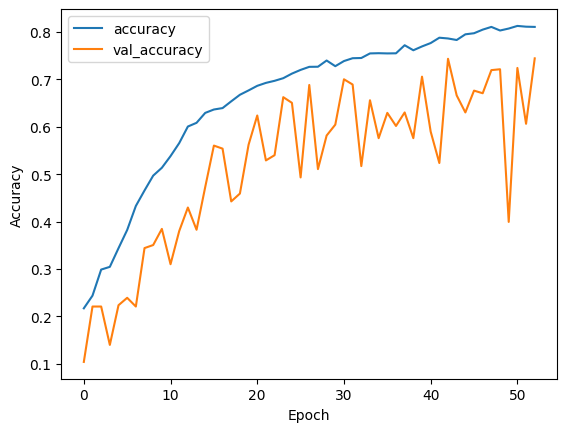

34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step


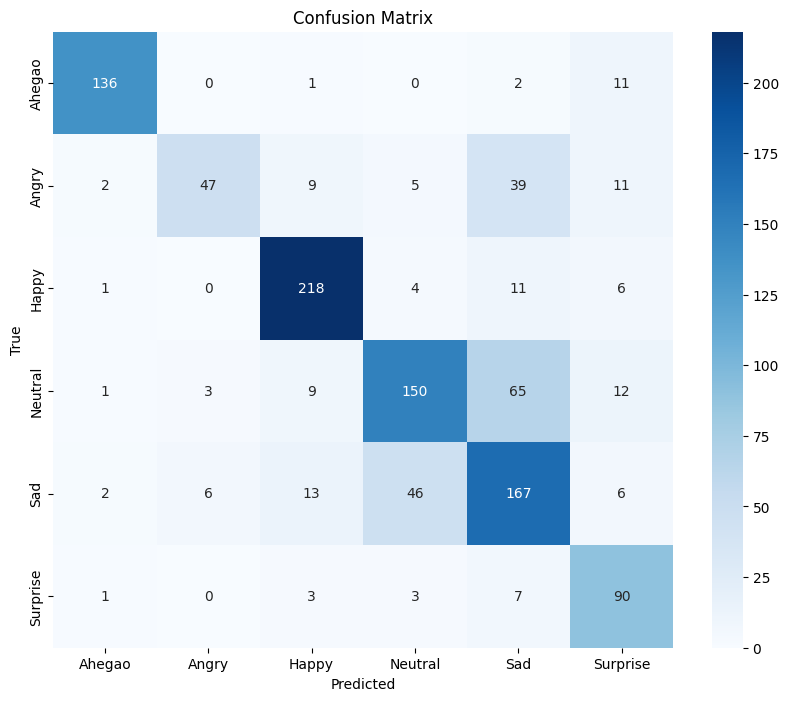

AUC Score: 0.9492232821365825
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       150
           1       0.84      0.42      0.56       113
           2       0.86      0.91      0.88       240
           3       0.72      0.62      0.67       240
           4       0.57      0.70      0.63       240
           5       0.66      0.87      0.75       104

    accuracy                           0.74      1087
   macro avg       0.77      0.74      0.74      1087
weighted avg       0.76      0.74      0.74      1087



In [9]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Generate predictions
y_pred = resmodel.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# AUC Score
auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print('AUC Score:', auc)

# Classification Report
print('Classification Report:\n', classification_report(y_true, y_pred_classes))

In [11]:


def residual_block(x, filters, kernel_size=3):
    res = Conv2D(filters, kernel_size, padding='same')(x)
    res = BatchNormalization()(res)
    res = LeakyReLU(alpha=0.1)(res)
    
    res = Conv2D(filters, kernel_size, padding='same')(res)
    res = BatchNormalization()(res)
    
    if x.shape[-1] != filters:
        x = Conv2D(filters, (1, 1), padding='same')(x)
        x = BatchNormalization()(x)
    
    x = Add()([x, res])
    x = LeakyReLU(alpha=0.1)(x)
    return x

input_layer = Input(shape=(256, 256, 1))
x = Conv2D(16, (3, 3), padding='same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x = residual_block(x, 32)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x = residual_block(x, 64)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.4)(x)

x = residual_block(x, 128)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.4)(x)

x = Conv2D(256, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)

x = Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.5)(x)

output_layer = Dense(y_train.shape[1], activation='softmax')(x)

res2model = Model(inputs=input_layer, outputs=output_layer)

optimizer = Adam(learning_rate=0.0001)
res2model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = res2model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 56s 496ms/step - accuracy: 0.1569 - loss: 4.1639 - val_accuracy: 0.2208 - val_loss: 3.4969 - learning_rate: 1.0000e-04
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 265ms/step - accuracy: 0.1872 - loss: 3.9637 - val_accuracy: 0.2208 - val_loss: 3.5585 - learning_rate: 1.0000e-04
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 259ms/step - accuracy: 0.1930 - loss: 3.8206 - val_accuracy: 0.2208 - val_loss: 3.4212 - learning_rate: 1.0000e-04
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 263ms/step - accuracy: 0.2124 - loss: 3.7157 - val_accuracy: 0.2208 - val_loss: 3.4599 - learning_rate: 1.0000e-04
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 264ms/step - accuracy: 0.2231 - loss: 3.5817 - val_accuracy: 0.2208 - val_loss: 3.4456 - learning_rate: 1.0000e-04
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 262ms/step - accuracy: 0.2371 - loss: 3.5022 - val_accuracy: 0.2208 - val_loss: 3.4654 - learning_rate: 1.0000e-04
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 263ms/ste

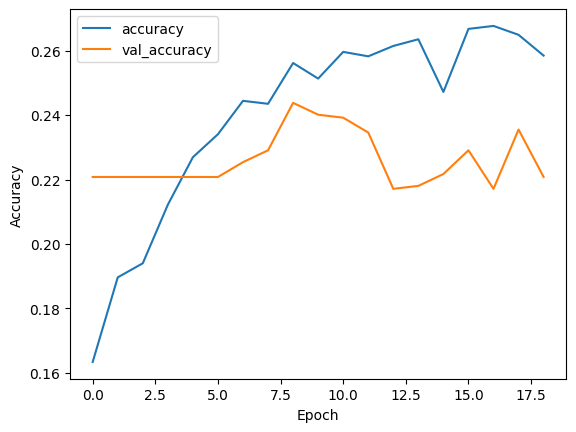

34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step


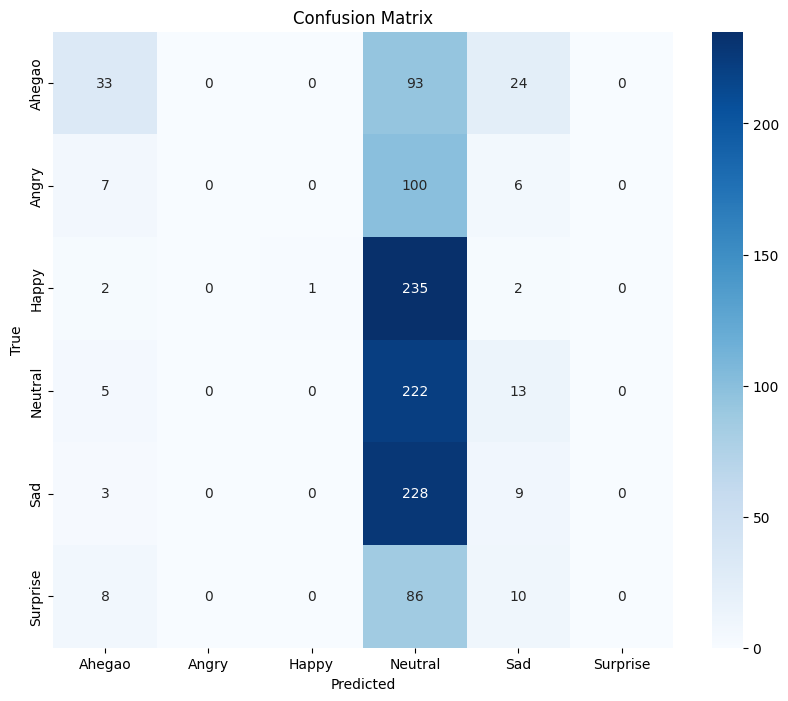

AUC Score: 0.6557759859698291
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.22      0.32       150
           1       0.00      0.00      0.00       113
           2       1.00      0.00      0.01       240
           3       0.23      0.93      0.37       240
           4       0.14      0.04      0.06       240
           5       0.00      0.00      0.00       104

    accuracy                           0.24      1087
   macro avg       0.32      0.20      0.13      1087
weighted avg       0.38      0.24      0.14      1087



In [12]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Generate predictions
y_pred = res2model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# AUC Score
auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
print('AUC Score:', auc)

# Classification Report
print('Classification Report:\n', classification_report(y_true, y_pred_classes))

In [13]:

num_classes = y_train.shape[1]

def residual_block(x, filters, kernel_size=3):
    res = Conv2D(filters, kernel_size, padding='same')(x)
    res = BatchNormalization()(res)
    res = LeakyReLU(alpha=0.1)(res)
    
    res = Conv2D(filters, kernel_size, padding='same')(res)
    res = BatchNormalization()(res)
    
    if x.shape[-1] != filters:
        x = Conv2D(filters, (1, 1), padding='same')(x)
        x = BatchNormalization()(x)
    
    x = Add()([x, res])
    x = LeakyReLU(alpha=0.1)(x)
    return x

class CNNHyperModel(HyperModel):
    def build(self, hp):
        input_layer = Input(shape=(256, 256, 1))
        x = Conv2D(hp.Int('conv_1_filters', min_value=32, max_value=128, step=32), (3, 3), padding='same')(input_layer)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1))(x)

        x = Conv2D(hp.Int('conv_2_filters', min_value=64, max_value=256, step=64), (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1))(x)

        x = Flatten()(x)
        
        x = Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1))(x)

        output_layer = Dense(num_classes, activation='softmax')(x)

        model = Model(inputs=input_layer, outputs=output_layer)

        model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
        return model

hypermodel = CNNHyperModel()
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir',
    project_name='cnn_tuning'
)

tuner.search(datagen.flow(X_train, y_train, batch_size=64), epochs=50, validation_data=(X_test, y_test))
best_model = tuner.get_best_models(num_models=1)[0]


Trial 3 Complete [00h 00m 29s]

Best val_accuracy So Far: 0.4001840054988861
Total elapsed time: 00h 30m 41s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
96                |128               |conv_1_filters
0.3               |0.4               |dropout_1
192               |128               |conv_2_filters
0.3               |0.4               |dropout_2
384               |512               |dense_units
0.2               |0.3               |dropout_3



Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 155, in _build_hypermodel
    model

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 155, in _build_hypermodel
    model = self.hypermodel.build(hp)
  File "/opt/conda/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 120, in _build_wrapper
    return self._build(hp, *args, **kwargs)
  File "/tmp/ipykernel_34/1212700444.py", line 36, in build
    x = Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
  File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py", line 5883, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access
tensorflow.python.framework.errors_impl.ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[786432,384] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2] name: 


In [14]:

class_labels = list(label_encoder.classes_)
with open('class_labels.pkl', 'wb') as f:
    pickle.dump(class_labels, f)